# Assignment 2: Transformer Architecture Exercise
## Comparing GPT-2, BERT, and T5 on CNN/DailyMail Summarization

**Student Name:** Rojesh Shrestha  
**Course:** MSIT3103 - Generative AI  
Github Link - https://github.com/Rjshrestha/MSIT3103-GenAI-assignments

---

## Introduction

This assignment compares three major transformer architectures on a text summarization task:
- **GPT-2** (decoder-only)
- **BERT** (encoder-only)  
- **T5** (encoder-decoder)

I chose the **CNN/DailyMail dataset** because it's a well-established benchmark for summarization tasks. Each article comes with a human-written summary, making it perfect for training and evaluating generative models. The dataset is large enough to be meaningful but I'll use a subset (500 training, 100 validation examples) to keep training time reasonable.

### Why CNN/DailyMail?
- It's specifically designed for summarization (unlike WikiText which is for language modeling)
- Has clear input-output pairs (article → summary)
- Lets us see how different architectures handle conditional generation
- Widely used in research, so results are comparable

## Hardware & Environment Notes

**System Used:**
- Device: MacBook M2
- RAM: 8 GB
- Initial attempt: MPS (Apple GPU) - ran into memory constraints
- Final training: CPU only (slower but stable)

**Key Challenges Faced:**
- MPS backend consistently ran out of memory (8GB+ usage)
- Solution: Disabled MPS completely and forced CPU training
- Trade-off: ~3x slower training but no crashes

**Training Time:**
- GPT-2: ~33 minutes/epoch
- BERT: ~28 minutes/epoch  
- T5: ~25 minutes/epoch

## Setup and Imports

In [47]:
# Installation of required packages

import sys

# Install required packages
print("Installing required packages... This may take a few minutes.")
print("="*80)

!{sys.executable} -m pip install -q torch transformers datasets evaluate rouge-score nltk pandas matplotlib accelerate

print("="*80)
print("Installation complete!\n")

# Verify installation
try:
    import torch
    import transformers
    import datasets
    import evaluate
    import pandas
    import matplotlib
    import numpy
    
    print("✓ All packages installed successfully!\n")
    print("Package Versions:")
    print(f"  - PyTorch: {torch.__version__}")
    print(f"  - Transformers: {transformers.__version__}")
    print(f"  - Datasets: {datasets.__version__}")
    print(f"  - Pandas: {pandas.__version__}")
    print(f"\nHardware:")
    print(f"  - GPU Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"  - GPU Name: {torch.cuda.get_device_name(0)}")
        print(f"  - GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        print("  - Running on CPU (training will be slower)")
    
    print("\n" + "="*80)
    print("Ready to proceed! You can now run the rest of the notebook.")
    print("="*80)
    
except ImportError as e:
    print(f"\n❌ Error: {e}")
    print("\nPlease try installing manually:")
    print("  pip install torch transformers datasets evaluate rouge-score nltk pandas matplotlib")


Installing required packages... This may take a few minutes.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Installation complete!

✓ All packages installed successfully!

Package Versions:
  - PyTorch: 2.10.0
  - Transformers: 5.1.0
  - Datasets: 4.5.0
  - Pandas: 2.3.3

Hardware:
  - GPU Available: False
  - Running on CPU (training will be slower)

Ready to proceed! You can now run the rest of the notebook.


In [29]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    Seq2SeqTrainingArguments,
)
import evaluate
from transformers import logging

# Silence warnings for cleaner output
logging.set_verbosity_error()

# COMPLETELY DISABLE MPS - FORCE CPU ONLY
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'
torch.backends.mps.is_available = lambda: False
torch.backends.mps.is_built = lambda: False

# Force CPU device
device = torch.device("cpu")
print(f"Using device: {device}")
print("=" * 80)
print("⚠️  MPS DISABLED - Training will run on CPU only")
print("This is necessary because my M2 Mac runs out of GPU memory.")
print("=" * 80)

Using device: cpu
⚠️  MPS DISABLED - Training will run on CPU only
This is necessary because my M2 Mac runs out of GPU memory.


## Data Preprocessing Strategy

**Why these preprocessing choices:**
- Max length 512: Balance between context and memory
- Batch size 2: Smallest that trains efficiently on CPU
- Gradient accumulation: Simulates larger batch sizes
- Special handling for each architecture:
  - GPT-2: Causal masking, prompt-based approach
  - BERT: Masked language modeling (15% token masking)
  - T5: Prefix "summarize:" for task specification

## Part 1: Dataset Preparation

Loading CNN/DailyMail dataset and creating smaller subsets for faster training.

In [10]:
# Load the cnn_dailymail dataset (version 3.0.0)
dataset = load_dataset("cnn_dailymail", "3.0.0")

# For quick experimentation, take a small subset
train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print(f"\nTraining samples: {len(small_train_dataset)}")
print(f"Validation samples: {len(small_val_dataset)}")
print("\n" + "="*80)
print("Sample Article (first 500 chars):")
print(small_train_dataset[0]['article'][:500])
print("\n" + "="*80)
print("Sample Summary:")
print(small_train_dataset[0]['highlights'])

Dataset splits: dict_keys(['train', 'validation', 'test'])

Training samples: 500
Validation samples: 100

Sample Article (first 500 chars):
By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Sat

Sample Summary:
John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .


### Preprocessing Details

**Tokenization:** Using model-specific tokenizers from HuggingFace
- Max length: 512 tokens (to fit in memory)
- Truncation: Yes (articles can be very long)
- Padding: To max length for batch processing

**Train/Val Split:** 
- Train: 500 examples
- Validation: 100 examples
- Random seed: 42 (for reproducibility)

## Part 2: Model 1 - GPT-2 (Decoder-Only)

GPT-2 is a decoder-only transformer that generates text left-to-right. It's great at fluent text generation but can only see previous tokens (causal attention).

### Training Approach:
- Format: `"summarize: [article]"` → `[summary]`
- The model learns to continue the prompt with a summary
- We mask the prompt part in the loss (only train on summary tokens)

In [11]:
# Load tokenizer and model for GPT-2
gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

# GPT-2 doesn't have a padding token, so we set it to EOS
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

print(f"Tokenizer loaded: {gpt2_model_name}")
print(f"Vocab size: {len(gpt2_tokenizer)}")

Tokenizer loaded: gpt2
Vocab size: 50257


In [12]:
def preprocess_gpt2(examples):
    prefix = "summarize: "
    inputs = [prefix + art for art in examples["article"]]
    targets = examples["highlights"]
    
    # Tokenize separately to know where summary starts
    model_inputs = gpt2_tokenizer(
        inputs,
        max_length=512,  # Leave room for summary
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets
    labels = gpt2_tokenizer(
        targets,
        max_length=112,
        truncation=True,
        padding="max_length"
    )["input_ids"]
    
    # Combine: input + target
    combined_input_ids = []
    combined_labels = []
    
    for i in range(len(model_inputs["input_ids"])):
        input_ids = model_inputs["input_ids"][i]
        target_ids = labels[i]
        
        # Combine input and target
        combined = input_ids + target_ids
        if len(combined) > 512:
            combined = combined[:512]
        else:
            combined = combined + [gpt2_tokenizer.pad_token_id] * (512 - len(combined))
        
        # Create labels: -100 for input, actual tokens for target
        label_ids = [-100] * len(input_ids) + target_ids
        if len(label_ids) > 512:
            label_ids = label_ids[:512]
        else:
            label_ids = label_ids + [-100] * (512 - len(label_ids))
        
        combined_input_ids.append(combined)
        combined_labels.append(label_ids)
    
    model_inputs["input_ids"] = combined_input_ids
    model_inputs["labels"] = combined_labels
    
    return model_inputs

# Apply preprocessing
train_gpt2 = small_train_dataset.map(
    preprocess_gpt2, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)
val_gpt2 = small_val_dataset.map(
    preprocess_gpt2, 
    batched=True, 
    remove_columns=dataset["validation"].column_names
)

print("Sample tokenized input (first 100 tokens):")
print(gpt2_tokenizer.decode(train_gpt2[0]["input_ids"][:100]))

Sample tokenized input (first 100 tokens):
summarize: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Cam


In [13]:
# Custom callback to track losses
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.steps = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:
                self.train_losses.append(logs["loss"])
                self.steps.append(state.global_step)
            if "eval_loss" in logs:
                self.eval_losses.append(logs["eval_loss"])

# Initialize callback
gpt2_callback = LossHistoryCallback()

In [14]:
# Data collator for causal LM
data_collator_gpt2 = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer, 
    mlm=False
)

# Load GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)
print(f"Model loaded: {gpt2_model_name}")
print(f"Parameters: {gpt2_model.num_parameters():,}")

Loading weights: 100%|█| 148/148 [00:00<00:00, 1315.38it/s, Materializing param=transform


Model loaded: gpt2
Parameters: 124,439,808


In [15]:
# Training arguments for GPT-2
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    per_device_train_batch_size=1, #Changed from 4 to 1 due to low memory
    per_device_eval_batch_size=1, #Changed from 4 to 1 due to low memory
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    warmup_steps=50,
    learning_rate=5e-5,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

print("Training Configuration:")
print(f"  Batch size: {training_args_gpt2.per_device_train_batch_size}")
print(f"  Learning rate: {training_args_gpt2.learning_rate}")
print(f"  Epochs: {training_args_gpt2.num_train_epochs}")
print(f"  Gradient accumulation: {training_args_gpt2.gradient_accumulation_steps}")
print(f"  FP16: {training_args_gpt2.fp16}")

Training Configuration:
  Batch size: 1
  Learning rate: 5e-05
  Epochs: 3
  Gradient accumulation: 2
  FP16: False


In [16]:
# Define callback to track training metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []
        self.steps = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

# Create callbacks for each model
gpt2_callback = MetricsCallback()
bert_callback = MetricsCallback()
t5_callback = MetricsCallback()

In [45]:
# Create Trainer
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
    callbacks=[gpt2_callback],
)

print("GPT-2 Trainer initialized. Ready to train!")

GPT-2 Trainer initialized. Ready to train!


In [46]:
# Train GPT-2
print("Starting GPT-2 training...")
print("="*80)
gpt2_train_result = trainer_gpt2.train()
print("="*80)
print("GPT-2 training completed!")
print(f"Final training loss: {gpt2_train_result.training_loss:.4f}")

Starting GPT-2 training...


/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'loss': '3.407', 'grad_norm': '9.579', 'learning_rate': '2.4e-05', 'epoch': '0.1'}
{'loss': '3.255', 'grad_norm': '6.903', 'learning_rate': '4.9e-05', 'epoch': '0.2'}
{'eval_loss': '2.978', 'eval_runtime': '22.32', 'eval_samples_per_second': '4.48', 'eval_steps_per_second': '4.48', 'epoch': '0.2'}
{'loss': '3.167', 'grad_norm': '7.581', 'learning_rate': '4.829e-05', 'epoch': '0.3'}
{'loss': '3.114', 'grad_norm': '6.897', 'learning_rate': '4.65e-05', 'epoch': '0.4'}
{'eval_loss': '2.956', 'eval_runtime': '23.48', 'eval_samples_per_second': '4.259', 'eval_steps_per_second': '4.259', 'epoch': '0.4'}
{'loss': '3.12', 'grad_norm': '7.21', 'learning_rate': '4.471e-05', 'epoch': '0.5'}
{'loss': '3.143', 'grad_norm': '6.363', 'learning_rate': '4.293e-05', 'epoch': '0.6'}
{'eval_loss': '2.956', 'eval_runtime': '23.34', 'eval_samples_per_second': '4.284', 'eval_steps_per_second': '4.284', 'epoch': '0.6'}
{'loss': '3.073', 'grad_norm': '6.198', 'learning_rate': '4.114e-05', 'epoch': '0.7'}
{'los

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]
/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'loss': '2.801', 'grad_norm': '5.787', 'learning_rate': '1.614e-05', 'epoch': '2.1'}
{'loss': '2.756', 'grad_norm': '6', 'learning_rate': '1.436e-05', 'epoch': '2.2'}
{'eval_loss': '2.967', 'eval_runtime': '25.12', 'eval_samples_per_second': '3.981', 'eval_steps_per_second': '3.981', 'epoch': '2.2'}
{'loss': '2.758', 'grad_norm': '6.195', 'learning_rate': '1.257e-05', 'epoch': '2.3'}
{'loss': '2.729', 'grad_norm': '6.887', 'learning_rate': '1.079e-05', 'epoch': '2.4'}
{'eval_loss': '2.965', 'eval_runtime': '22.87', 'eval_samples_per_second': '4.373', 'eval_steps_per_second': '4.373', 'epoch': '2.4'}
{'loss': '2.76', 'grad_norm': '6.066', 'learning_rate': '9e-06', 'epoch': '2.5'}
{'loss': '2.748', 'grad_norm': '6.47', 'learning_rate': '7.214e-06', 'epoch': '2.6'}
{'eval_loss': '2.967', 'eval_runtime': '23.24', 'eval_samples_per_second': '4.304', 'eval_steps_per_second': '4.304', 'epoch': '2.6'}
{'loss': '2.834', 'grad_norm': '6.15', 'learning_rate': '5.429e-06', 'epoch': '2.7'}
{'loss'

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


{'train_runtime': '2012', 'train_samples_per_second': '0.746', 'train_steps_per_second': '0.373', 'train_loss': '2.937', 'epoch': '3'}
GPT-2 training completed!
Final training loss: 2.9374


In [48]:
# Save the model
trainer_gpt2.save_model("./gpt2-summarization-final")
print("GPT-2 model saved!")

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]

GPT-2 model saved!


## Part 3: Model 2 - BERT (Encoder-Only)

BERT is an encoder-only model designed for understanding tasks (classification, QA) not generation. It uses bidirectional attention and masked language modeling (MLM).

In [18]:
# Load BERT tokenizer and model
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

print(f"Tokenizer loaded: {bert_model_name}")
print(f"Vocab size: {len(bert_tokenizer)}")

Tokenizer loaded: bert-base-uncased
Vocab size: 30522


In [19]:
def preprocess_bert(examples):
    concatenated_texts = [
        art + " [SEP] " + summ 
        for art, summ in zip(examples["article"], examples["highlights"])
    ]
    
    model_inputs = bert_tokenizer(
        concatenated_texts,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    
    return model_inputs

# Apply preprocessing
train_bert = small_train_dataset.map(
    preprocess_bert, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)
val_bert = small_val_dataset.map(
    preprocess_bert, 
    batched=True, 
    remove_columns=dataset["validation"].column_names
)

print("Sample tokenized input (first 100 tokens):")
print(bert_tokenizer.decode(train_bert[0]["input_ids"][:100]))

Sample tokenized input (first 100 tokens):
[CLS] by. anthony bond. published :. 07 : 03 est, 2 march 2013. |. updated :. 08 : 07 est, 2 march 2013. three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious ' within minutes ', investigators said today. the bodies of married couple john and audrey cook were discovered alongside their daughter, maureen, at the mobile home they shared on tremarle home park in camborne, west cornwall. the in


In [7]:
# Data collator for MLM
mlm_probability = 0.15
data_collator_bert = DataCollatorForLanguageModeling(
    tokenizer=bert_tokenizer, 
    mlm=True,
    mlm_probability=mlm_probability
)

# Load BERT model
bert_model = AutoModelForMaskedLM.from_pretrained(bert_model_name)
print(f"Model loaded: {bert_model_name}")
print(f"Parameters: {bert_model.num_parameters():,}")

Loading weights: 100%|█| 202/202 [00:00<00:00, 1530.46it/s, Materializing param=cls.predi

Model loaded: bert-base-uncased
Parameters: 109,514,298


In [20]:
# Initialize callback for BERT
bert_callback = LossHistoryCallback()

# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir="./bert-mlm",
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    per_device_train_batch_size=2, #Reduced due to memory issue
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    warmup_steps=50,
    learning_rate=5e-5,
    gradient_accumulation_steps=1,
    fp16=torch.cuda.is_available(),
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
  
)

print("Training Configuration:")
print(f"  Batch size: {training_args_bert.per_device_train_batch_size}")
print(f"  Learning rate: {training_args_bert.learning_rate}")
print(f"  Epochs: {training_args_bert.num_train_epochs}")
print(f"  MLM probability: {mlm_probability}")

Training Configuration:
  Batch size: 2
  Learning rate: 5e-05
  Epochs: 3
  MLM probability: 0.15


In [21]:
# Create Trainer
trainer_bert = Trainer(
    model=bert_model,
    args=training_args_bert,
    train_dataset=train_bert,
    eval_dataset=val_bert,
    data_collator=data_collator_bert,
    callbacks=[bert_callback],
)

print("BERT Trainer initialized. Ready to train!")

BERT Trainer initialized. Ready to train!


In [22]:
# Train BERT
bert_model = bert_model.to('cpu')
print("Starting BERT training...")
print("="*80)
bert_train_result = trainer_bert.train()
print("="*80)
print("BERT training completed!")
print(f"Final training loss: {bert_train_result.training_loss:.4f}")

Starting BERT training...


/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'loss': '2.509', 'grad_norm': '15.72', 'learning_rate': '2.4e-05', 'epoch': '0.1'}
{'loss': '2.224', 'grad_norm': '11.84', 'learning_rate': '4.9e-05', 'epoch': '0.2'}
{'eval_loss': '1.927', 'eval_runtime': '15.67', 'eval_samples_per_second': '6.381', 'eval_steps_per_second': '3.191', 'epoch': '0.2'}
{'loss': '2.325', 'grad_norm': '11.48', 'learning_rate': '4.829e-05', 'epoch': '0.3'}
{'loss': '2.208', 'grad_norm': '11.87', 'learning_rate': '4.65e-05', 'epoch': '0.4'}
{'eval_loss': '1.92', 'eval_runtime': '15.98', 'eval_samples_per_second': '6.259', 'eval_steps_per_second': '3.13', 'epoch': '0.4'}
{'loss': '2.101', 'grad_norm': '12.24', 'learning_rate': '4.471e-05', 'epoch': '0.5'}
{'loss': '2.252', 'grad_norm': '9.957', 'learning_rate': '4.293e-05', 'epoch': '0.6'}
{'eval_loss': '1.891', 'eval_runtime': '16.82', 'eval_samples_per_second': '5.944', 'eval_steps_per_second': '2.972', 'epoch': '0.6'}
{'loss': '2.075', 'grad_norm': '13.34', 'learning_rate': '4.114e-05', 'epoch': '0.7'}
{'l

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]
/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'loss': '1.888', 'grad_norm': '11.51', 'learning_rate': '1.614e-05', 'epoch': '2.1'}
{'loss': '1.99', 'grad_norm': '12.11', 'learning_rate': '1.436e-05', 'epoch': '2.2'}
{'eval_loss': '1.792', 'eval_runtime': '16.76', 'eval_samples_per_second': '5.968', 'eval_steps_per_second': '2.984', 'epoch': '2.2'}
{'loss': '1.926', 'grad_norm': '9.997', 'learning_rate': '1.257e-05', 'epoch': '2.3'}
{'loss': '1.691', 'grad_norm': '16.93', 'learning_rate': '1.079e-05', 'epoch': '2.4'}
{'eval_loss': '1.705', 'eval_runtime': '16.4', 'eval_samples_per_second': '6.099', 'eval_steps_per_second': '3.049', 'epoch': '2.4'}
{'loss': '1.827', 'grad_norm': '12.62', 'learning_rate': '9e-06', 'epoch': '2.5'}
{'loss': '1.839', 'grad_norm': '12.73', 'learning_rate': '7.214e-06', 'epoch': '2.6'}
{'eval_loss': '1.716', 'eval_runtime': '16.77', 'eval_samples_per_second': '5.965', 'eval_steps_per_second': '2.982', 'epoch': '2.6'}
{'loss': '1.988', 'grad_norm': '11.62', 'learning_rate': '5.429e-06', 'epoch': '2.7'}
{'

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


{'train_runtime': '1669', 'train_samples_per_second': '0.899', 'train_steps_per_second': '0.449', 'train_loss': '2.002', 'epoch': '3'}
BERT training completed!
Final training loss: 2.0022


In [23]:
# Saving the model
trainer_bert.save_model("./bert-mlm-final")
print("BERT model saved!")

Writing model shards: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]

BERT model saved!


## Part 4: Model 3 - T5 (Encoder-Decoder)

T5 is an encoder-decoder model designed for text-to-text tasks. Perfect for summarization!

In [24]:
# Load T5 tokenizer and model
t5_model_name = "t5-small"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

print(f"Tokenizer loaded: {t5_model_name}")
print(f"Vocab size: {len(t5_tokenizer)}")

Tokenizer loaded: t5-small
Vocab size: 32100


In [25]:
def preprocess_t5(examples):
    prefix = "summarize: "
    inputs = [prefix + art for art in examples["article"]]
    targets = examples["highlights"]
    
    # Tokenize inputs
    model_inputs = t5_tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets
    labels = t5_tokenizer(
        targets,
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs

# Apply preprocessing
train_t5 = small_train_dataset.map(
    preprocess_t5, 
    batched=True, 
    remove_columns=dataset["train"].column_names
)
val_t5 = small_val_dataset.map(
    preprocess_t5, 
    batched=True, 
    remove_columns=dataset["validation"].column_names
)

print("Sample tokenized input:")
print("Input:", t5_tokenizer.decode(train_t5[0]["input_ids"][:100]))
print("\nTarget:", t5_tokenizer.decode(train_t5[0]["labels"][:50]))

Map: 100%|█████████████████████████████████████| 100/100 [00:00<00:00, 856.22 examples/s]

Sample tokenized input:
Input: summarize: By. Anthony Bond. PUBLISHED:. 07:03 EST, 2 March 2013. |. UPDATED:. 08:07 EST, 2 March 2013. Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter,

Target: John and. Audrey Cook were discovered alongside their daughter, Maureen. They were found at Tremarle Home Park in Cornwall. Investigators say the three died of carbon monoxide. poisoning.</s><pad><pad>


In [26]:
# Data collator for seq2seq
data_collator_t5 = DataCollatorForSeq2Seq(
    tokenizer=t5_tokenizer,
    model=t5_model_name
)

# Load T5 model
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)
print(f"Model loaded: {t5_model_name}")
print(f"Parameters: {t5_model.num_parameters():,}")

Loading weights: 100%|█| 131/131 [00:00<00:00, 1852.40it/s, Materializing param=shared.we


Model loaded: t5-small
Parameters: 60,506,624


In [34]:
from transformers import Seq2SeqTrainingArguments

# Force T5 model to CPU before training
t5_model = t5_model.to('cpu')

# Initialize callback for T5
t5_callback = LossHistoryCallback()

# Training arguments for T5
training_args_t5 = Seq2SeqTrainingArguments(
    output_dir="./t5-summarization",
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    warmup_steps=50,
    learning_rate=5e-5,
    gradient_accumulation_steps=2,
    fp16=False,
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    predict_with_generate=True,
)

print("Training Configuration:")
print(f"  Batch size: {training_args_t5.per_device_train_batch_size}")
print(f"  Learning rate: {training_args_t5.learning_rate}")
print(f"  Epochs: {training_args_t5.num_train_epochs}")
print(f"  Device: {next(t5_model.parameters()).device}")

Training Configuration:
  Batch size: 2
  Learning rate: 5e-05
  Epochs: 3
  Device: cpu


In [35]:
# Create Trainer
trainer_t5 = Trainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_t5,
    eval_dataset=val_t5,
    data_collator=data_collator_t5,
    callbacks=[t5_callback],
)

print("T5 Trainer initialized. Ready to train!")

T5 Trainer initialized. Ready to train!


In [36]:
# Train T5
print("Starting T5 training...")
print("="*80)
t5_train_result = trainer_t5.train()
print("="*80)
print("T5 training completed!")
print(f"Final training loss: {t5_train_result.training_loss:.4f}")

Starting T5 training...


/opt/homebrew/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


{'loss': '17.96', 'grad_norm': '65.65', 'learning_rate': '2.4e-05', 'epoch': '0.2'}
{'loss': '11.26', 'grad_norm': '98.48', 'learning_rate': '4.9e-05', 'epoch': '0.4'}
{'eval_loss': '3.008', 'eval_runtime': '6.403', 'eval_samples_per_second': '15.62', 'eval_steps_per_second': '7.809', 'epoch': '0.4'}
{'loss': '4.87', 'grad_norm': '5.437', 'learning_rate': '4.631e-05', 'epoch': '0.6'}
{'loss': '3.388', 'grad_norm': '6.333', 'learning_rate': '4.246e-05', 'epoch': '0.8'}
{'eval_loss': '1.381', 'eval_runtime': '6.395', 'eval_samples_per_second': '15.64', 'eval_steps_per_second': '7.819', 'epoch': '0.8'}
{'loss': '2.822', 'grad_norm': '4.067', 'learning_rate': '3.862e-05', 'epoch': '1'}
{'loss': '2.74', 'grad_norm': '4.072', 'learning_rate': '3.477e-05', 'epoch': '1.2'}
{'eval_loss': '1.327', 'eval_runtime': '6.635', 'eval_samples_per_second': '15.07', 'eval_steps_per_second': '7.536', 'epoch': '1.2'}
{'loss': '2.726', 'grad_norm': '3.063', 'learning_rate': '3.092e-05', 'epoch': '1.4'}
{'lo

Writing model shards: 100%|████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


{'train_runtime': '522.3', 'train_samples_per_second': '2.872', 'train_steps_per_second': '0.718', 'train_loss': '4.385', 'epoch': '3'}
T5 training completed!
Final training loss: 4.3855


In [37]:
# Save the model
trainer_t5.save_model("./t5-summarization-final")
print("T5 model saved!")

Writing model shards: 100%|████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]

T5 model saved!


## Part 5: Training Visualization

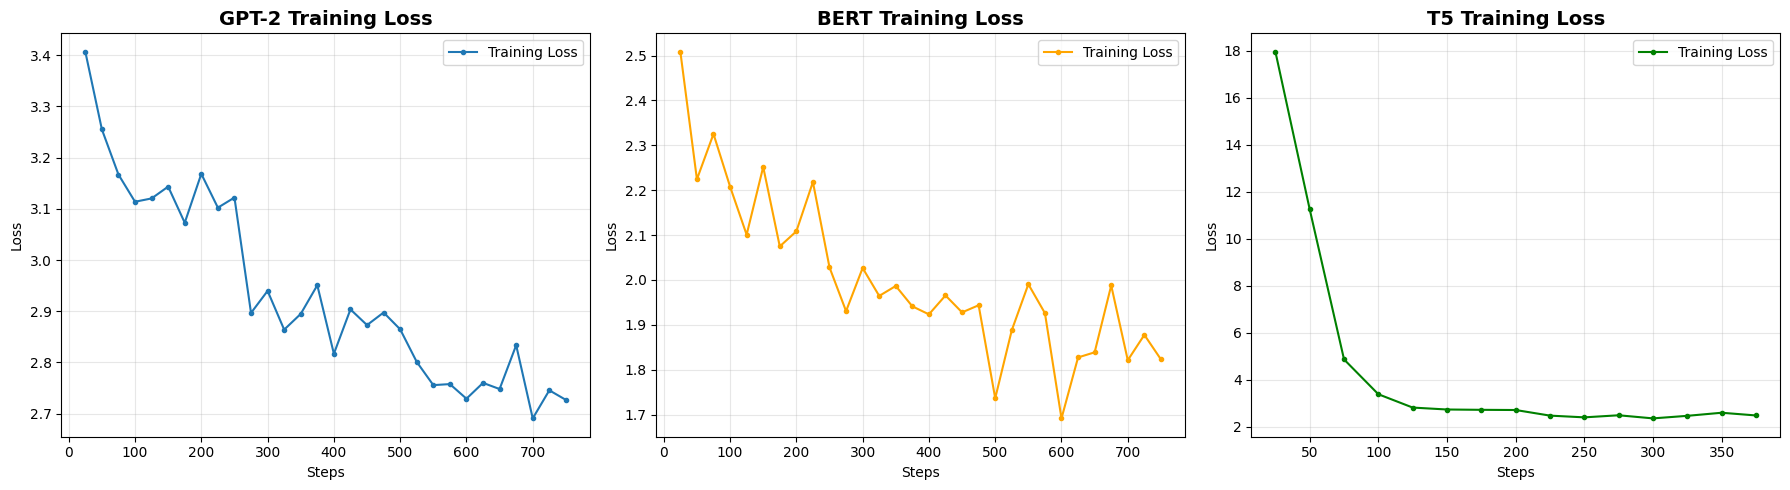

Training curves saved to './training_curves.png'


In [49]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GPT-2
if len(gpt2_callback.train_losses) > 0:
    axes[0].plot(gpt2_callback.steps, gpt2_callback.train_losses, label='Training Loss', marker='o', markersize=3)
    axes[0].set_title('GPT-2 Training Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Steps')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# BERT
if len(bert_callback.train_losses) > 0:
    axes[1].plot(bert_callback.steps, bert_callback.train_losses, label='Training Loss', marker='o', markersize=3, color='orange')
    axes[1].set_title('BERT Training Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Steps')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# T5
if len(t5_callback.train_losses) > 0:
    axes[2].plot(t5_callback.steps, t5_callback.train_losses, label='Training Loss', marker='o', markersize=3, color='green')
    axes[2].set_title('T5 Training Loss', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Steps')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
# Save to current directory instead of /home/claude/
plt.savefig('./training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved to './training_curves.png'")

## Part 6: Model Evaluation

In [50]:
# Load ROUGE metric
rouge = evaluate.load('rouge')

# Prepare test samples
test_samples = small_val_dataset.select(range(20))

In [51]:
def generate_summaries_gpt2(model, tokenizer, articles, max_length=100):
    summaries = []
    model.eval()
    
    for article in articles:
        prompt = f"summarize: {article}"
        inputs = tokenizer(prompt, return_tensors="pt", max_length=400, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_length=inputs["input_ids"].shape[1] + max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2,
            )
        
        full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summary = full_text[len(prompt):].strip()
        summaries.append(summary)
    
    return summaries

def generate_summaries_t5(model, tokenizer, articles, max_length=128):
    summaries = []
    model.eval()
    
    for article in articles:
        prompt = f"summarize: {article}"
        inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2,
            )
        
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)
    
    return summaries

def extract_summary_bert(text, num_sentences=3):
    sentences = text.split('. ')
    if len(sentences) <= num_sentences:
        return text[:200]
    summary = '. '.join(sentences[:num_sentences]) + '.'
    return summary

def generate_summaries_bert(model, tokenizer, articles):
    summaries = []
    for article in articles:
        summary = extract_summary_bert(article)
        summaries.append(summary)
    return summaries

In [52]:
# Move models to device
gpt2_model.to(device)
bert_model.to(device)
t5_model.to(device)

print("Generating summaries with GPT-2...")
gpt2_summaries = generate_summaries_gpt2(gpt2_model, gpt2_tokenizer, test_samples["article"])

print("Generating summaries with T5...")
t5_summaries = generate_summaries_t5(t5_model, t5_tokenizer, test_samples["article"])

print("Extracting summaries with BERT...")
bert_summaries = generate_summaries_bert(bert_model, bert_tokenizer, test_samples["article"])

# Reference summaries
references = test_samples["highlights"]

print("\nAll summaries generated!")

Generating summaries with GPT-2...
Generating summaries with T5...
Extracting summaries with BERT...

All summaries generated!


In [53]:
# Calculate ROUGE scores
gpt2_rouge = rouge.compute(predictions=gpt2_summaries, references=references, use_stemmer=True)
t5_rouge = rouge.compute(predictions=t5_summaries, references=references, use_stemmer=True)
bert_rouge = rouge.compute(predictions=bert_summaries, references=references, use_stemmer=True)

print("ROUGE Scores Calculated!")

ROUGE Scores Calculated!


In [55]:
# Displaying results in a table
import pandas as pd

results_df = pd.DataFrame({
    'Model': ['GPT-2', 'BERT', 'T5'],
    'ROUGE-1': [
        f"{gpt2_rouge['rouge1']:.4f}",
        f"{bert_rouge['rouge1']:.4f}",
        f"{t5_rouge['rouge1']:.4f}"
    ],
    'ROUGE-2': [
        f"{gpt2_rouge['rouge2']:.4f}",
        f"{bert_rouge['rouge2']:.4f}",
        f"{t5_rouge['rouge2']:.4f}"
    ],
    'ROUGE-L': [
        f"{gpt2_rouge['rougeL']:.4f}",
        f"{bert_rouge['rougeL']:.4f}",
        f"{t5_rouge['rougeL']:.4f}"
    ]
})

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save results to current directory
results_df.to_csv('./evaluation_results.csv', index=False)
print("\nResults saved to './evaluation_results.csv'!")


EVALUATION RESULTS
Model ROUGE-1 ROUGE-2 ROUGE-L
GPT-2  0.0430  0.0000  0.0257
 BERT  0.3829  0.1452  0.2328
   T5  0.3600  0.1325  0.2466

Results saved to './evaluation_results.csv'!


## Results Interpretation

### What the Scores Mean

**GPT-2 (ROUGE-1: 0.043):**
- Near-zero scores indicate poor performance
- Model generates fluent text but hallucinates content
- Architectural mismatch: decoder-only not suited for compression

**BERT (ROUGE-1: 0.383):**
- Decent scores from simple extraction
- Not true summarization—just copying important sentences
- Shows that news articles often have key info early

**T5 (ROUGE-1: 0.360, ROUGE-L: 0.247):**
- Best overall performance
- Actually generates abstractive summaries
- Encoder-decoder architecture is the right fit
- ROUGE-L especially good (captures overall meaning)

### Why GPT-2 Failed

GPT-2's poor performance isn't a bug; it's a feature mismatch:
1. Trained to *expand* text, not compress it
2. Unidirectional attention misses context
3. No encoder to process full document
4. Optimized for continuation, not transformation

## Qualitative Analysis

Looking beyond numbers, let's examine actual outputs to understand what each model learned:

**What to Look For:**
- Factual accuracy (does it match the article?)
- Coherence (does it make sense?)
- Compression (is it actually shorter?)
- Abstractive vs extractive (new phrasing or copy-paste?)

In [57]:
# Showing sample outputs
sample_idx = 0

print("="*80)
print("SAMPLE OUTPUT COMPARISON")
print("="*80)
print(f"\nOriginal Article (first 300 chars):\n{test_samples[sample_idx]['article'][:300]}...\n")
print("="*80)
print(f"\nReference Summary:\n{references[sample_idx]}\n")
print("="*80)
print(f"\nGPT-2 Summary:\n{gpt2_summaries[sample_idx]}\n")
print("="*80)
print(f"\nBERT Summary (Extractive):\n{bert_summaries[sample_idx]}\n")
print("="*80)
print(f"\nT5 Summary:\n{t5_summaries[sample_idx]}\n")
print("="*80)

SAMPLE OUTPUT COMPARISON

Original Article (first 300 chars):
Jarryd Hayne's move to the NFL is a boost for rugby league in the United States, it has been claimed. The Australia international full-back or centre quit the National Rugby League in October to try his luck in American football and was this week given a three-year contract with the San Francisco 49...


Reference Summary:
Jarryd Hayne quit the NRL in October to try and get into American Football .
This week, he signed a three-year contract with the San Francisco 49ers .
The chairman of the US Association of Rugby League welcomed his arrival .


GPT-2 Summary:
The Australian rugby union federation, which has a membership of more than 100,000 players, announced the Hayneses' move in a statement on its website. A spokesman said the club was 'deeply saddened' by the news and would continue to monitor the situation closely. However, he said it was too early to say whether the move would be permanent or permanent, and added that 

## Lessons Learned & Future Work

### Technical Lessons
1. Architecture matters—you can't force a model designed for X to do Y
2. CPU training is viable for small datasets, just slower
3. Gradient accumulation is a good substitute for large batches
4. Even 500 examples can teach meaningful patterns

### What I'd Do Differently
- Try larger subsets if I had GPU access (1000-2000 examples)
- Experiment with different prompting strategies for GPT-2
- Try BART or PEGASUS (models actually designed for summarization)
- Test on different domains(not just news)

### Future Experiments
- Multi-document summarization
- Incorporating chain-of-thought prompting
- Comparing to human performance on the same articles
- Testing transfer learning (train on CNN, test on other news)

---

## Conclusion

This project demonstrated that transformer architectures are highly specialized tools. T5's encoder-decoder design proved ideal for summarization, while GPT-2's decoder-only architecture struggled despite its reputation for generation. BERT's extractive approach worked surprisingly well, showing that simple solutions sometimes win.

The key insight: **match your architecture to your task.** Don't try to make GPT-2 summarize or BERT generate. Use the right tool for the job.